# TDA Tutorial: 3-D Manifolds
By: J. E. Umaña and Victor M. Zavala

Database was constructed using RDKit and NIST ILThermo Database.

Based on work done by J. E. Umaña & Dr. Ryan K. Cashen and uploaded [here](https://chemrxiv.org/engage/chemrxiv/article-details/673e51a17be152b1d0f96fd9).

To access this notebook in Google Colab, please click below:

<a href="https://githubtocolab.com/zavalab/Tutorials/blob/master/CBE660/Graph_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

# ***Introduction***

**Predictive Modeling**

* This notebook tutorial details the construction of a neural network model for materials properties prediction using molecular graph representations. This tutorial exhibits general data normalization and regression which can be generalized to broader chemical engineering applications.

* In this exmample, our model utilizes a dataset of molecular information from RDKit to predict real temperature-dependent experimental properties (viscosity, density, heat capacity) for ionic liquids from ILThermo using a graph neural network regression model.


**Ionic Liquids**

* Ionic liquids are an emerging non-flammable, non-volatile electrolyte material with growing interest in application for energy storage purposes due to their sustainable and tunable properties.

* Ionic liquids are composed of organic and inorganic ion cores with highly tunable substituent functional groups. This is promising for application-specific electrolyte design, and it is estimate that greater than 10^6 possible ionic liquid materials.

* Given the large number of possible ionic liquids, it is impossible to synthesize and evaluate all of these materials. Further, the complex interactions in these ionic fluids invalidates the assumptions of many classical property models. Instead, neural networks can be used to model these complex property relationships.

* Here, we will use graph neural networks to predict the properties of ionic liquids based on published experimental property measurements.

***Graph Neural Networks***

* A graph is a set of nodes and connecting edges. For a simple graph, these edges are undirected and nodes can have up to 1 edge connecting them. Connected nodes are called neighbors.

* Here, we will utilize a form of simple graphs called adjacency matrices which will depict a molecule's atoms as nodes and bonds as edges. Atoms which are covalently bonded will be neighbor nodes.

* Adjacency matrices depend on the ordering of atoms as nodes, so in this case, we will use RDKit to create adjacency matrices with uniform ordering to create consistent graph representations of our desired ionic liquid molecules.

* A graph neural network will use these graphs as inputs to an artificial neural network architecture. Artificial neural networks require vector inputs, so these graphs will be transformed into vectors to be input to the neural network. In this case we will flatten our matrices by concatenating rows one after the other.

* Neural networks are organized into 3 layers of nodes: input, output, and hidden layers. Nodes in a hidden layer each model a linear portion of a more complex relationship, and their combination can approximate even non-linear, non-continous, and non-smooth relationships. This allows neural networks to approximate any variable relationship.

* As many structure-property relationships do not have known analytical relations, neural networks become very useful for modeling complex molecular contributions to materials properties. See more information about neural networks in the Neural_Networks.ipynb tutorial.

* An example graph neural network for this tutorial is shown below.

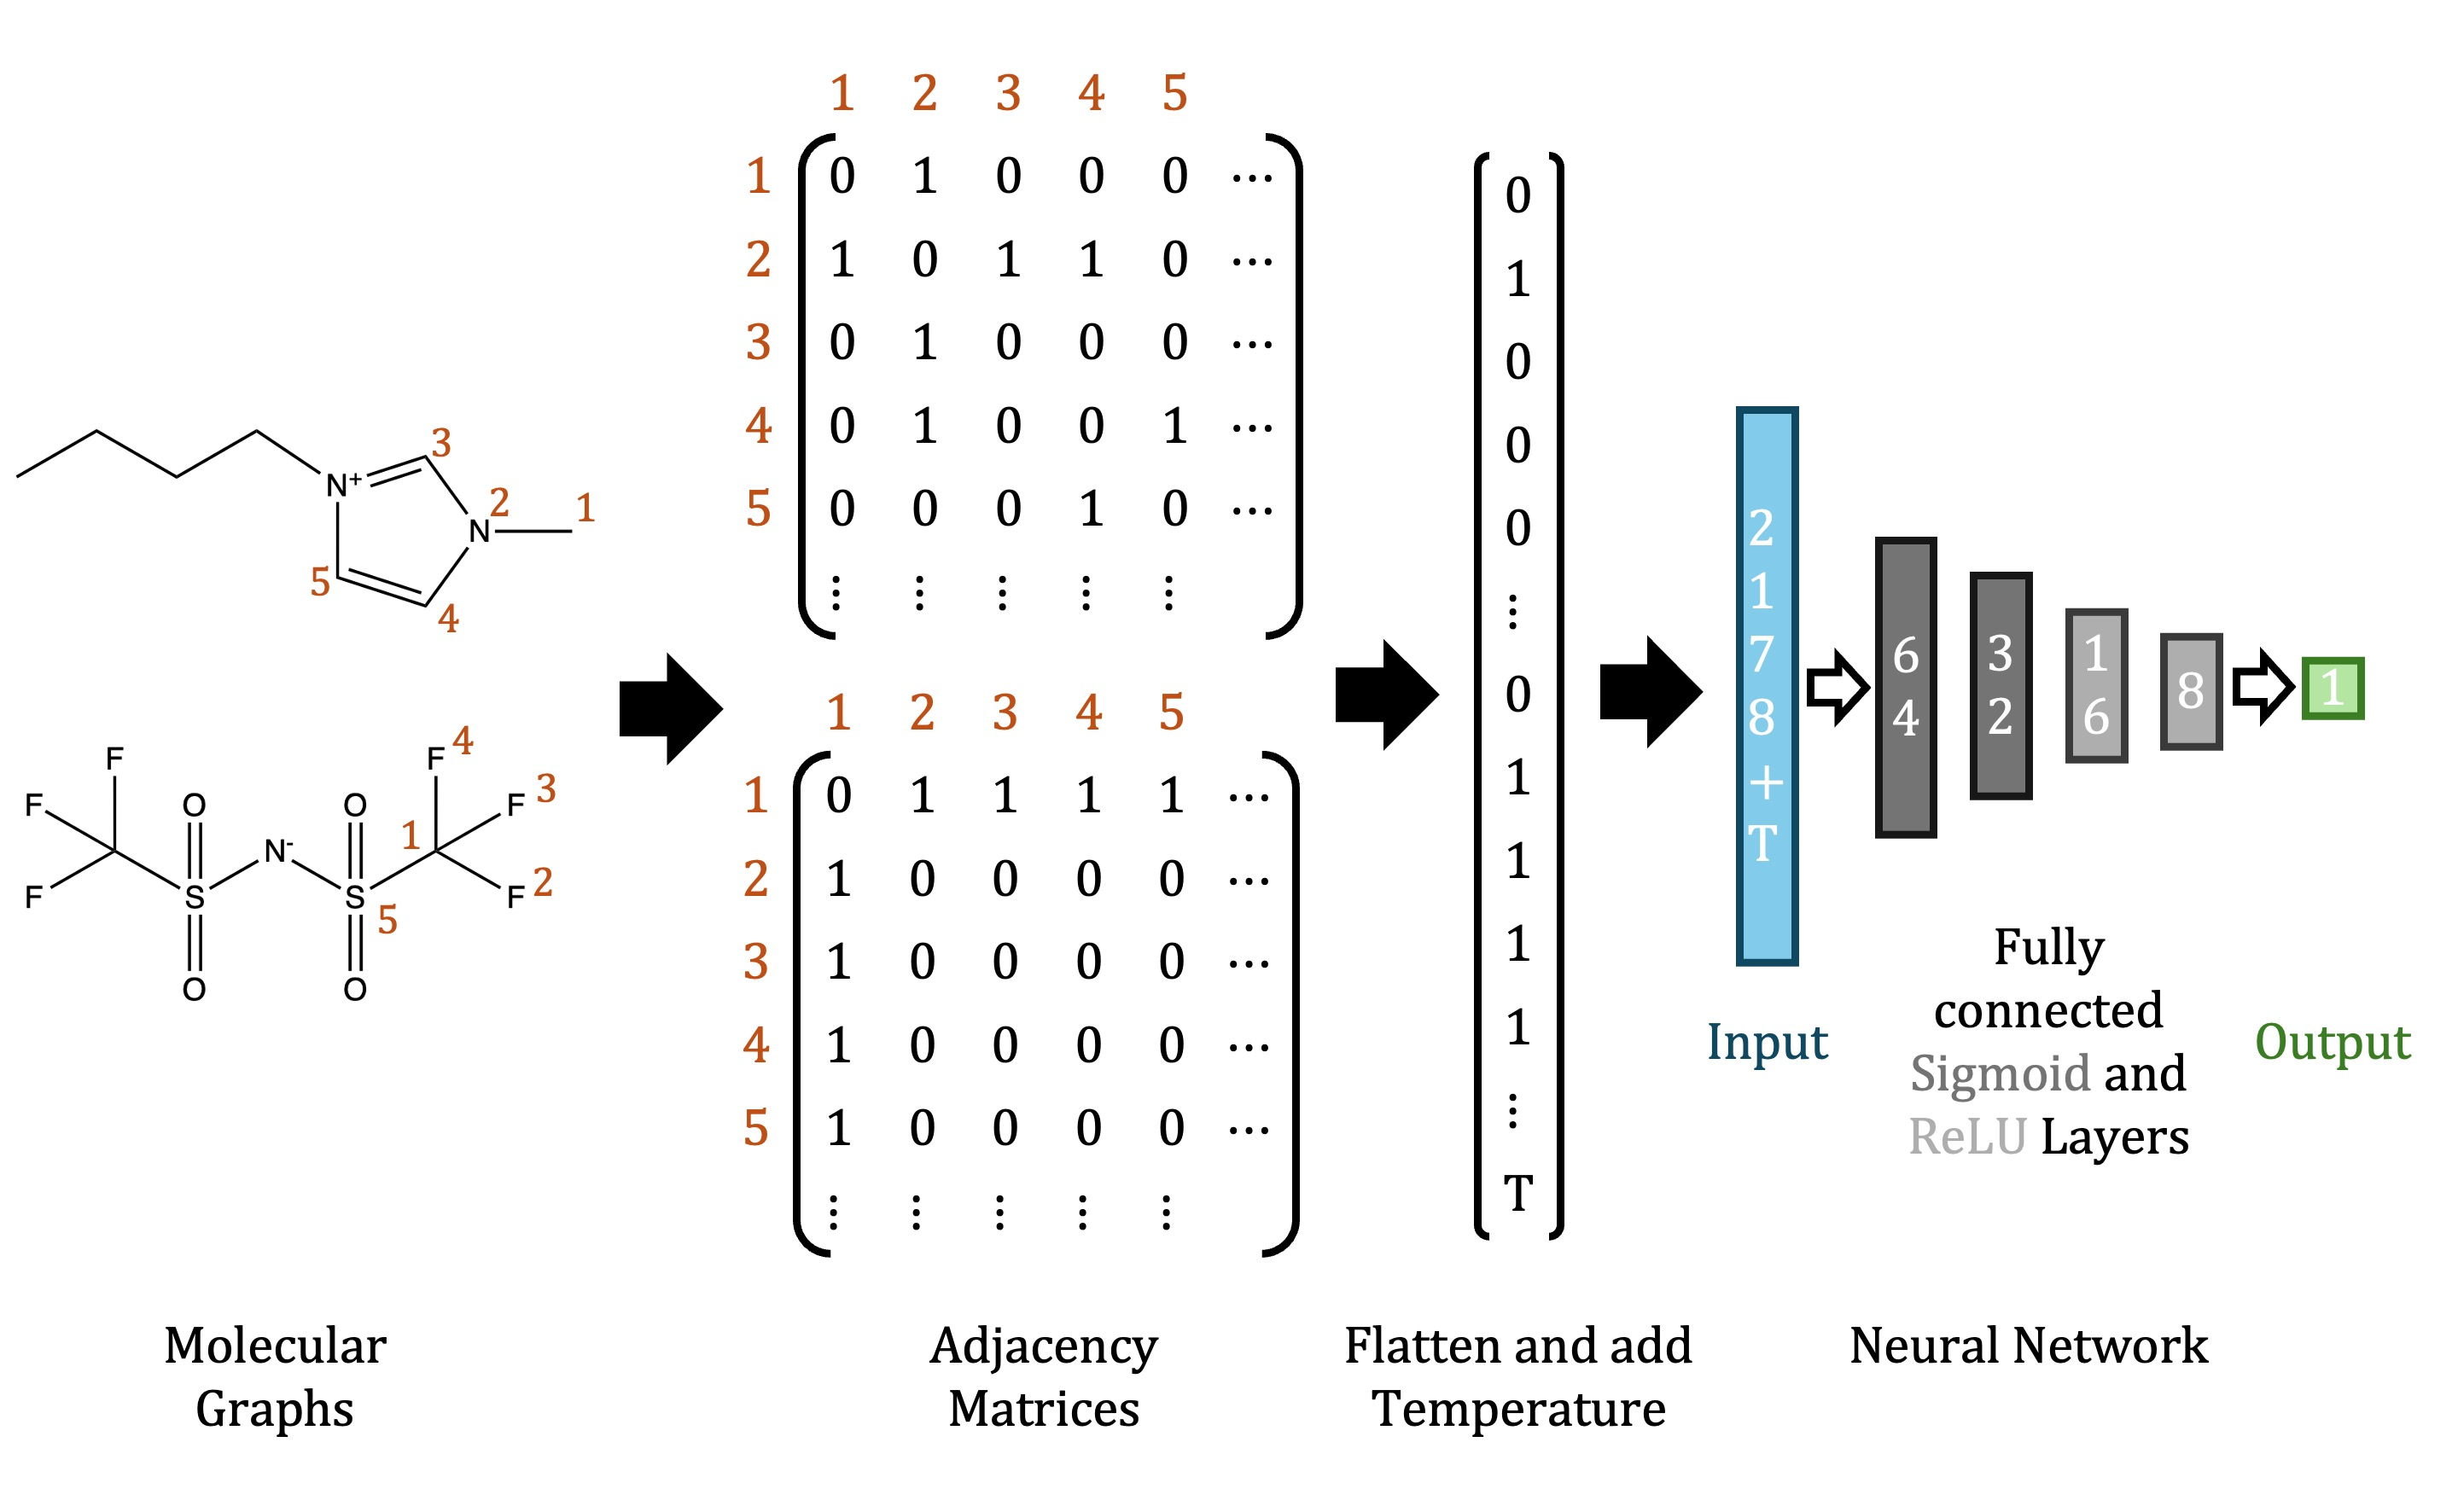

# ***Import Data***

In [15]:
# Import relevant packages for data importing.

import numpy as np # NumPy is a computing package for python. More info here: https://numpy.org/doc/stable/
import pandas as pd # Pandas enables the use of DataFrames for data visualization and management. More info here: https://pandas.pydata.org/

In [16]:
!git clone https://github.com/zavalab/Tutorials.git
import os
os.chdir('Tutorials/CBE660/Data/')

Cloning into 'IL_Neural_Networks'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 60 (delta 26), reused 52 (delta 18), pack-reused 0 (from 0)
Receiving objects: 100% (60/60), 31.37 MiB | 14.89 MiB/s, done.
Resolving deltas: 100% (26/26), done.
Updating files: 100% (27/27), done.


* We can now choose which property we would like to model by uncommenting (deleting the '#' character) the corresponding line below.

* This tutorial utilizes 3 sets of experimental properties which can be predicted, heat capacity, density, and viscosity.

* Consider that these properties will be modeled by molecular connectivity. Which ionic liquid properties do you think can be predicted from such information? Make a prediction now, and compare this to your final results.

In [56]:
# Choose data to model

# data, units = pd.read_csv('RDKit_Heat_capacity_data.csv'), '(J/mol/K)' # Uncomment to use heat capacity data for ionic liquids
# data, units = pd.read_csv('RDKit_Density_data.csv'), '(Kg/m^3' # Uncomment to use density data for ionic liquids
# data, units = pd.read_csv('RDKit_Viscosity_data.csv'), '(Paᐧs)' # Uncomment to use viscosity data for ionic liquids
data, units = pd.read_csv('RDKit_Molar_conductivity_data.csv'), '(Sᐧcm^2/mol)' # Uncomment to use molar conductivity data for ionic liquids
# data, units = pd.read_csv('RDKit_Melting_temperature_data.csv'), '(K)' # Uncomment to use melting temperature data for ionic liquids

In [57]:
# Visualize the dataset

print('Our dataset is size: ' + str(data.shape) + '\n')
data.head(5) # This shows the 1st 5 entries of our DataFrame


Our dataset is size: (2224, 47)



,Name,Atom Count_Cation,Atom Count_Anion,Volume_Cation,Volume_Anion,Radius_Cation,Radius_Anion,Volume Cation/Volume Anion,Polar Area_Cation,Polar Area_Anion,...,Max Partial Charge_Anion,Asphericity Cation_StDev%,Spherocity_Cation_StDev%,Asphericity Anion_StDev%,Spherocity_Anion_StDev%,SMILES_Anion,SMILES_Cation,Mols_Cation,Mols_Anion,Molar Conductivity
0,"['1-butyl-1-methylpyrrolidinium', 'tricyanomet...",30,7,167.69648,81.77344,3.420937e-10,2.692617e-10,2.050745,0.0,48.6,...,0.14811,20.059394,8.605392,1.027727e-07,190.922456,C(=C(C#N)C#N)=[N-],CCCC[N+]1(CCCC1)C,<rdkit.Chem.rdchem.Mol object at 0x7f880b47def0>,<rdkit.Chem.rdchem.Mol object at 0x7f880cc50c70>,2.360223
1,"['1-butyl-1-methylpyrrolidinium', 'tricyanomet...",30,7,167.69648,81.77344,3.420937e-10,2.692617e-10,2.050745,0.0,48.6,...,0.14811,20.059394,8.605392,1.027727e-07,190.922456,C(=C(C#N)C#N)=[N-],CCCC[N+]1(CCCC1)C,<rdkit.Chem.rdchem.Mol object at 0x7f880b47def0>,<rdkit.Chem.rdchem.Mol object at 0x7f880cc50c70>,0.888282
2,"['1-butyl-1-methylpyrrolidinium', 'tricyanomet...",30,7,167.69648,81.77344,3.420937e-10,2.692617e-10,2.050745,0.0,48.6,...,0.14811,20.059394,8.605392,1.027727e-07,190.922456,C(=C(C#N)C#N)=[N-],CCCC[N+]1(CCCC1)C,<rdkit.Chem.rdchem.Mol object at 0x7f880b47def0>,<rdkit.Chem.rdchem.Mol object at 0x7f880cc50c70>,4.830183
3,"['1-butyl-1-methylpyrrolidinium', 'tricyanomet...",30,7,167.69648,81.77344,3.420937e-10,2.692617e-10,2.050745,0.0,48.6,...,0.14811,20.059394,8.605392,1.027727e-07,190.922456,C(=C(C#N)C#N)=[N-],CCCC[N+]1(CCCC1)C,<rdkit.Chem.rdchem.Mol object at 0x7f880b47def0>,<rdkit.Chem.rdchem.Mol object at 0x7f880cc50c70>,1.725149
4,"['1-butyl-1-methylpyrrolidinium', 'tricyanomet...",30,7,167.69648,81.77344,3.420937e-10,2.692617e-10,2.050745,0.0,48.6,...,0.14811,20.059394,8.605392,1.027727e-07,190.922456,C(=C(C#N)C#N)=[N-],CCCC[N+]1(CCCC1)C,<rdkit.Chem.rdchem.Mol object at 0x7f880b47def0>,<rdkit.Chem.rdchem.Mol object at 0x7f880cc50c70>,3.934452


* To predict ionic liquid properties, we will only need chemical identity and target output information.

* Here we will use SMILES to construct our molecular graphs. SMILES are created from a molecules 2D structure. Learn more about the rules for constructing SMILES representations here: https://archive.epa.gov/med/med_archive_03/web/html/smiles.html

In [58]:
Identity_data = pd.concat((data[['Name', 'SMILES_Cation', 'SMILES_Anion', 'Temperature']], data.iloc[:,-1]), axis=1)
Identity_data.head(5)

,Name,SMILES_Cation,SMILES_Anion,Temperature,Molar Conductivity
0,"['1-butyl-1-methylpyrrolidinium', 'tricyanomet...",CCCC[N+]1(CCCC1)C,C(=C(C#N)C#N)=[N-],304,2.360223
1,"['1-butyl-1-methylpyrrolidinium', 'tricyanomet...",CCCC[N+]1(CCCC1)C,C(=C(C#N)C#N)=[N-],278,0.888282
2,"['1-butyl-1-methylpyrrolidinium', 'tricyanomet...",CCCC[N+]1(CCCC1)C,C(=C(C#N)C#N)=[N-],333,4.830183
3,"['1-butyl-1-methylpyrrolidinium', 'tricyanomet...",CCCC[N+]1(CCCC1)C,C(=C(C#N)C#N)=[N-],294,1.725149
4,"['1-butyl-1-methylpyrrolidinium', 'tricyanomet...",CCCC[N+]1(CCCC1)C,C(=C(C#N)C#N)=[N-],323,3.934452


# ***Visualize Our Dataset***

In [59]:
# %pip install rdkit #Uncomment if rdkit is not installed

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors, Descriptors3D, Draw, rdMolDescriptors, PandasTools

import networkx as nx
import matplotlib.pyplot as plt

***Molecular Structure Viewer***

* We can view ionic liquids in our DataFrame to see the variety of structures we will be predicting.

* Below, we will visualize the molecular structure, adjacency matrix representation, and graph representation.

Molecular Name: ['1-Propyl-2-methylpyridinium', 'Bistriflylimide anion']
Data at Temperature: 313 K
Measurement Value: 1.5045247601906062 (Sᐧcm^2/mol)



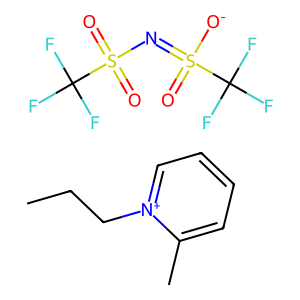

In [60]:
Ionic_Liquid_number = 40 # Choose an data entry to visualize

print('Molecular Name: '+str(data['Name'][Ionic_Liquid_number]))
print('Data at Temperature: '+str(data['Temperature'][Ionic_Liquid_number])+' K')
print('Measurement Value: '+str(data.iloc[:,-1][Ionic_Liquid_number])+' '+str(units)+'\n')

# Here we print out the 2D structure of our selected molecule
Chem.Draw.MolToImage(Chem.MolFromSmiles(str(data['SMILES_Cation'][Ionic_Liquid_number])+'.'+str(data['SMILES_Anion'][Ionic_Liquid_number])))

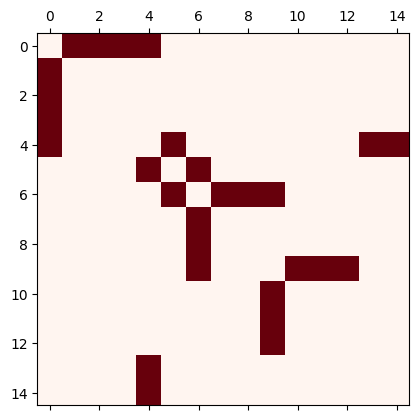

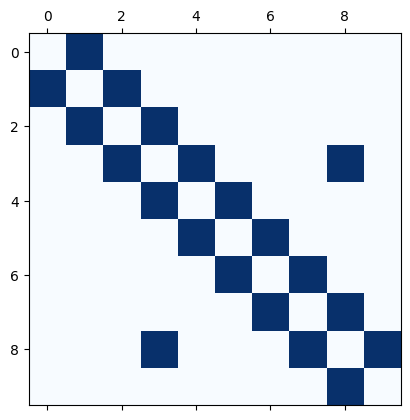

In [61]:
# Next we visualize the adjacency matrices.
# Ones (edges) are shown as dark colors and zeros (no edges) are shown as light colors.
# Anions are shown in red (Top Matrix) and cations are shown in blue (Bottom Matrix).

plt.matshow(Chem.GetAdjacencyMatrix(Chem.MolFromSmiles(data['SMILES_Anion'][Ionic_Liquid_number])), cmap='Reds')
plt.matshow(Chem.GetAdjacencyMatrix(Chem.MolFromSmiles(data['SMILES_Cation'][Ionic_Liquid_number])), cmap='Blues')

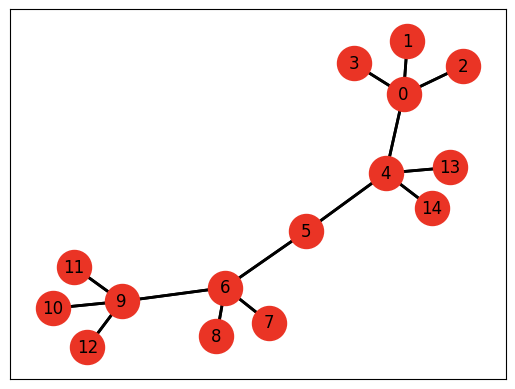

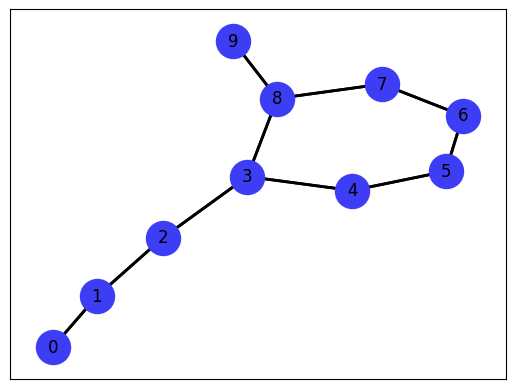

In [62]:
# Now we can visualize our graph representations.
# Anions are shown in red (Top Matrix) and cations are shown in blue (Bottom Matrix).
# Note that physical positions are not relevant for the nodes, only the connections between nodes.

plt.figure(1)
nx.draw_networkx(nx.DiGraph(Chem.GetAdjacencyMatrix(Chem.MolFromSmiles(data['SMILES_Anion'][Ionic_Liquid_number]))), arrows=False, node_size=600, node_color='#EA3425', width=2)
plt.figure(2)
nx.draw_networkx(nx.DiGraph(Chem.GetAdjacencyMatrix(Chem.MolFromSmiles(data['SMILES_Cation'][Ionic_Liquid_number]))), arrows=False, node_size=600, node_color='#3D3DF6', width=2)

# ***Data Cleaning***

* Before performing any predictive modeling, we must first create a suitable dataset.

* We will remove duplicate data points to make sure our data is evenly distributed. Duplicate data points can change our model to be more accurate for overly represented data points.

* Here, we will remove datapoints with the same ionic liquid at the same temperature as these are duplicate experimental conditions.

In [63]:
# To clean our data, let's drop duplicate data for ionic liquids. Here we remove data with both duplicate ionic liquids and temperature

New_data = Identity_data.drop_duplicates(subset=['Name', 'Temperature'])

In [64]:
print('Our new dataset is size: ' + str(New_data.shape) + '\n')
New_data # Here is our non-duplicated data data

Our new dataset is size: (1709, 5)



,Name,SMILES_Cation,SMILES_Anion,Temperature,Molar Conductivity
0,"['1-butyl-1-methylpyrrolidinium', 'tricyanomet...",CCCC[N+]1(CCCC1)C,C(=C(C#N)C#N)=[N-],304,2.360223
1,"['1-butyl-1-methylpyrrolidinium', 'tricyanomet...",CCCC[N+]1(CCCC1)C,C(=C(C#N)C#N)=[N-],278,0.888282
2,"['1-butyl-1-methylpyrrolidinium', 'tricyanomet...",CCCC[N+]1(CCCC1)C,C(=C(C#N)C#N)=[N-],333,4.830183
3,"['1-butyl-1-methylpyrrolidinium', 'tricyanomet...",CCCC[N+]1(CCCC1)C,C(=C(C#N)C#N)=[N-],294,1.725149
4,"['1-butyl-1-methylpyrrolidinium', 'tricyanomet...",CCCC[N+]1(CCCC1)C,C(=C(C#N)C#N)=[N-],323,3.934452
...,...,...,...,...,...
2219,"['3-hexyl-1-methylimidazolium', 'tricyanometha...",CCCCCCN1C=C[N+](=C1)C,C(=C(C#N)C#N)=[N-],298,0.883255
2220,"['3-hexyl-1-methylimidazolium', 'tricyanometha...",CCCCCCN1C=C[N+](=C1)C,C(=C(C#N)C#N)=[N-],283,0.349905
2221,"['1-methyl-3-octylimidazolium', 'tricyanometha...",CCCCCCCCN1C=C[N+](=C1)C,C(=C(C#N)C#N)=[N-],283,0.209152
2222,"['1-methyl-3-octylimidazolium', 'tricyanometha...",CCCCCCCCN1C=C[N+](=C1)C,C(=C(C#N)C#N)=[N-],293,0.426705


In [65]:
# Now let's create a dataset containing only our numerical data for modeling and a dataset containing our non-numerical data for record-keeping

numerical_data = New_data.select_dtypes(include=np.number).dropna(axis=1) # We only want numerical data for modeling purposes
ID_data = New_data.select_dtypes(exclude=np.number) # We create a seperate dataset with the non-numerical data

In [66]:
numerical_data.head(5) # We can view the numerical data

,Temperature,Molar Conductivity
0,304,2.360223
1,278,0.888282
2,333,4.830183
3,294,1.725149
4,323,3.934452


In [67]:
ID_data.head(5) # We can view the non-numerical data

,Name,SMILES_Cation,SMILES_Anion
0,"['1-butyl-1-methylpyrrolidinium', 'tricyanomet...",CCCC[N+]1(CCCC1)C,C(=C(C#N)C#N)=[N-]
1,"['1-butyl-1-methylpyrrolidinium', 'tricyanomet...",CCCC[N+]1(CCCC1)C,C(=C(C#N)C#N)=[N-]
2,"['1-butyl-1-methylpyrrolidinium', 'tricyanomet...",CCCC[N+]1(CCCC1)C,C(=C(C#N)C#N)=[N-]
3,"['1-butyl-1-methylpyrrolidinium', 'tricyanomet...",CCCC[N+]1(CCCC1)C,C(=C(C#N)C#N)=[N-]
4,"['1-butyl-1-methylpyrrolidinium', 'tricyanomet...",CCCC[N+]1(CCCC1)C,C(=C(C#N)C#N)=[N-]


**Create Input and Output Datasets**

* Now we must create our flattened adjacency matrices to be input to our model and specify what data will be the target output to be approximated by our model.

* We will also scale our Temperature input and our outputs to have a mean of 0 and standard deviation of 1. This will center our data and help with the machine learning model traning process.

In [68]:
from sklearn.preprocessing import StandardScaler # Import a package to scale our data to a mean of 0 and standard deviation of 1

In [69]:
# Create flattened adjacency matrix inputs.

Cations = ID_data.SMILES_Cation # Create list of cation SMILES.
Anions = ID_data.SMILES_Anion # Create list of anion SMILES.

k = 0
Cation_matrices = np.zeros(Cations.shape[0]).tolist()
Anion_matrices = np.zeros(Anions.shape[0]).tolist()
Full_matrices = np.zeros(Anions.shape[0]).tolist()

for i in Cations.index: # Loop over all cation and anions.
    Cation_matrices[k] = Chem.GetAdjacencyMatrix(Chem.MolFromSmiles(Cations[i])) # Create adjacency matrix for cation.
    Cation_matrices[k] = np.pad(Cation_matrices[k], (0,33-Cation_matrices[k].shape[0]), 'constant', constant_values=(0)).flatten() # Make all matrices 33x33 for uniform sizing and flatten.

    Anion_matrices[k] = Chem.GetAdjacencyMatrix(Chem.MolFromSmiles(Anions[i])) # Create adjacency matrix for anion.
    Anion_matrices[k] = np.pad(Anion_matrices[k], (0,33-Anion_matrices[k].shape[0]), 'constant', constant_values=(0)).flatten() # Make all matrices 33x33 for uniform sizing and flatten.

    Full_matrices[k] = np.concatenate((Cation_matrices[k], Anion_matrices[k])) # Combine cation and anion vector.

    k += 1

Temp_scale = StandardScaler() # Scale temperature to have a mean of 0 and standard deviation of 1.

if units != '(K)':
  X_scaled = pd.concat((pd.DataFrame(Full_matrices), pd.DataFrame(Temp_scale.fit_transform(numerical_data[['Temperature']]))), axis=1) # Add temperature to our cation and anion vector.

else:
  X_scaled = pd.DataFrame(Full_matrices)

In [70]:
# Create output dataset, Y.

# We will use the .iloc[] function to select our data.
# .iloc[] uses numerical indices to select data, where the 1st number is the rown and the 2nd is the column, similar to matrices and arrays.

Y_data = numerical_data.iloc[:,-1] # Selects only the last column which contains our target property.

In [71]:
# Scale the data.
# Scalers such as Standardscaler() will transform our data and can be called to undo the transormation.
# We will use .to_numpy().reshape(-1,1) to create numpy arrays from our DataFrames and reshape them into the appropriate form for our scaler.

Y_Scaler = StandardScaler()

Y_scaled = pd.DataFrame(Y_Scaler.fit_transform(Y_data.to_numpy().reshape(Y_data.shape[0],-1))) # We sclae the output data


In [72]:
# Visualize our input data now that it is ready for machine learning!

X_scaled.head(5)

,0,1,2,3,4,5,6,7,8,9,...,2169,2170,2171,2172,2173,2174,2175,2176,2177,0
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.667394
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.951717
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.765119
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-1.161365
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.271149


In [73]:
# Visualize our output data now that it is ready for machine learning!

Y_scaled.head(5)

,0
0,0.287336
1,-0.488731
2,1.589599
3,-0.047501
4,1.117333


# ***Split Data into Test and Training Sets***

* We can now train our model by giving input data to a neural network and approximating the output data.

* In order to evaluate our model, however, we will need an unseen set of data for the model to approximate which will test the model performance.

* To do so, we will create split our data into a training set and a test set. In our case, we will use 80% of our data to train the model and call this data our training set, and reserve the other 20% of our data to test the model and call this data our test set.

* Finally, to be test our model for all available data, we will repeat this training and testing process 5 times to have every data point test the model exactly once.

* This process is called k-fold cross validation. In this case, k is 5 in our case. More about k-fold cross validation can be learned here: https://scikit-learn.org/stable/modules/cross_validation.html.

* In particular, we will use a group k-fold, where data is first grouped by ionic liquid name, then split the data into a training and test set. This ensures that the same ionic liquid, but at different temperatures, do not artificially improve our model performance by existing in the training and test set simultaneously.

In [74]:
from sklearn.model_selection import GroupKFold # Import test and train dataset splitting package

In [75]:
k_fold = int(5) # Here we create 5 splits of test set data that is organized to avoid placing the same ionic liqiud compound in both the training and test set


# These arrays will hold our 5 training and test set indices for the 5 cross validation iterations.
# This allows us to cross reference between our numerical and non-numerical data. This is important for grouping ionic liquids by name.
train_indices = [0.0]*k_fold
test_indices = [0.0]*k_fold

# These arrays will hold our 5 training and test set values for the 5 cross validation iterations.
# This will be used in training and testing our model.
Train_Input = [[]]*k_fold
Train_Target = [[]]*k_fold
Test_Input = [[]]*k_fold
Test_Target = [[]]*k_fold

# Now, we will split our data:
i = 0
gss = GroupKFold(n_splits=k_fold)

for train_idx, test_idx in gss.split(X_scaled, X_scaled, ID_data['Name']): # We split our data into train and test indices accordin to ionic liquid name.
    train_indices[i] = train_idx # We create training set indices.
    test_indices[i] = test_idx # We create test set indices.

    Train_Input[i] = X_scaled.iloc[train_indices[i].tolist(),:].values # We create training set inputs using the training set indices.
    Train_Target[i] = Y_scaled.iloc[train_indices[i].tolist(),:].values # We create training set outputs using the training set indices.

    Test_Input[i] = X_scaled.iloc[test_indices[i].tolist(),:].values # We create test set inputs using the test set indices.
    Test_Target[i] = Y_scaled.iloc[test_indices[i].tolist(),:].values # We create test set outputs using the test set indices.

    i += 1

# ***Construct Neural Network Model***

* Finally, we can create and train our neural network model!

* To create our model, we will specify the neural network model architecture by choosing the number of hidden layers, number of nodes, and each layer's activation functions.

* We will also adjust our training process by setting hyperparameters: learning rate and number of training steps (epochs) according to the model's performance. We will visualize the model's learning curve, to identify if the model has converged to an optimal solution. A learning curve plots model error vs the number of iteration steps taken and will let us know if the model has taken enough training steps.

* We will use sigmoid and ReLU activation functions for our modeling. Sigmoid activation functions transform our linear node outputs to exponentially approach 0 if negative, and 1 if positive. ReLU activation functions simply round any negative linear node outputs to 0 and does not round positive outputs. Sigmoid activation functions can be useful for limiting the effect of outliers, while ReLU activition functions are the simplest function which enables non-linearity. See possible activation functions here: https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity.


* We will use pytorch to create our neural network, and more information can be found here: https://pytorch.org/docs/stable/index.html.

In [76]:
import torch # import neural network packages
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import r2_score, mean_squared_error # Import model evaluation packages

In [77]:
# Construct the architecture of your model using pytorch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Here we select our cpu to be used to train the model.

class IL_GNN(nn.Module): # We define the neural network here.

    def __init__(self): # We create a function to initailize the model when it is called. This will set the presets for the model to be used.
        super(IL_GNN, self).__init__() # We initialize the model.

        # Here we specify the input to the model.
        # Input layer:
        self.n_input = Train_Input[0][0].shape[0] # We set the input size to be the number of columns/features in our dataset

        # Here we specify the architecture of the model.
          # Each layer consists of a linear relationship between the number of inputs and number of outputs and an activation function.
          #
        self.main = nn.Sequential(
            # Layer 1:
            nn.Linear(self.n_input, 64), # We specify the 1st input layer to have be 64 nodes. We must specify the size of he input from the input layer as well.
            nn.Sigmoid(), # We specify the activation function for the 1st layer.
            nn.Dropout(0.5), # We can drop out a fraction of weights to reset overfitting
            # Layer 2:
            nn.Linear(64,32), # We create a 2nd hidden layer of 32 nodes. We must specify the size of the input coming from layer 1 as well.
            nn.Sigmoid(), # We specify the activation function for the 2nd layer.
            nn.Dropout(0.0), # We can drop out a fraction of weights to reset overfitting
            # Layer 3:
            nn.Linear(32,16), # We create a 3rd hidden layer of 16 nodes. We must specify the size of the input coming from layer 2 as well.
            nn.ReLU(0), # We specify the activation function for the 3rd layer.
            nn.Dropout(0.0), # We can drop out a fraction of weights to reset overfitting
            # Layer 4
            nn.Linear(16,8), # We create a 4th hidden layer of 8 nodes. We must specify the size of the input coming from layer 3 as well.
            nn.ReLU(0), # We specify the activation function for the 4th layer.
            nn.Dropout(0.0), # We can drop out a fraction of weights to reset overfitting

            # To create additional layers we can simply add them as shown below.
            # Here is an example 5th layer with X nodes that is commented out:
#           nn.Linear(8,X), # We create a 5th hidden layer of X nodes. We must specify the size of the input coming from the previous layer as well.
#           nn.ReLU(0), # We specify the activation function for the 5th layer.
#           nn.Dropout(0.0) # We can drop out a fraction of weights to reset overfitting

            # Output Layer
            nn.Linear(8,1) # We create an output of 1 node which will output our desired property appoximation. We must specify the size of the the previous layer as well.
        )

    def forward(self,x): # We create a function to apply the model when called.
        return self.main(x)

def weights_init(m): # We create a function to randomize the the weights of the model when called. We will use this to reset the model during each k-fold interation.
    torch.manual_seed(5) # We specify a seed to set the model to the same initial weights every time it is reset.
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)

IL_gnn = IL_GNN().to(device) # This sets our neural network a variable that we can train and test.

In [78]:
# Specify hyperparameters for training the model.

criterion = nn.MSELoss() # We specify to use Mean Squared Error (MSE) as our evaluation metric for our neural network training process.
optim_i = optim.Adam(IL_gnn.parameters(), lr=0.000288) # We specify the step size of our numerical solver.
epochs = 800 # We set the number of steps the model will take during training.
batch = 256 # This is the number of ionic liquids which will be randomly used for training in each step.

torch.manual_seed(7777) # We set a random seed to ensure replicability.

# We will specify how often to save model performance data (to plot a learning curve) and print model performance data (to observe progress in real time).
Test_check = 10 # This is how frequently we will record the model's training progress.
Print_freq = 400 # This is how often our code will print the model's training progress.

# These are the arrays which will save our training model error for our learning curve.
Training_Losses = np.zeros((k_fold,epochs))
Test_Losses = np.zeros((k_fold,int(epochs/Test_check)))

# These arrays will store our final outputs for each k-fold iteration!
Train_pred = [0.0]*k_fold
Test_pred = [0.0]*k_fold

In [79]:
# Train the model. This may take a few minutes depending on your computing power.

for k in range(0,5): # We train 5 models using each of the 5 training sets.
    print('Model '+str(k)) # Print k-fold iteration.
    Train_order = np.arange(0,Train_Input[k].shape[0],batch) # Set the random order of training steps.
    IL_gnn.apply(weights_init) # Reset the neural network weights.

    for epoch in range(epochs): # We train the specified number of epochs (training steps or iterations).
        loss = 0.0 # We reset the error to 0 for each step.

        # Here the actual model training occurs.
        for i in Train_order: # A loop for the random training order.
            pred = IL_gnn.forward(torch.Tensor(np.stack(Train_Input[k][i:i+batch]))) # We calculate outputs using the current weights.
            optim_i.zero_grad() # We reset our optimizers derivatives to zero.
            loss_current = criterion(torch.Tensor(pred), torch.Tensor(np.array(Train_Target[k][i:i+batch]))) # We evaluate the error of the current neural network model predictions.
            loss_current.backward(retain_graph=True) # We calculate the derivative of our model weights and find the gradient for error minimization.
            optim_i.step() # We apply a numerical step to our neural network weights in the direction of error minimization.
            loss += loss_current.item()/(len(Train_order)) # We save the error of our model.

        # We record and print our model's training progress if the training step is a multiple of our specified checking frequencies.
        if epoch%Test_check == 0:
            T_pred = IL_gnn.forward(torch.Tensor(np.stack(Test_Input[k]))).detach().numpy() # We calculate the outputs for our test set
            Test_loss = mean_squared_error(T_pred, Test_Target[k]) # We calculate the error in our test set to evaluate the model
            Test_Losses[k][int(epoch/Test_check)] = Test_loss

        if epoch%Print_freq == 0:
            print('Epoch: ' + str(epoch) + ', Loss: ' + str(np.round(loss, 6)) + ', Test Loss: ' + str(np.round(Test_loss, 6)))

        Training_Losses[k][epoch] = loss

    # We predict the final outputs of our model's k-fold iteration.
    Train_pred[k] =  IL_gnn.forward(torch.Tensor(np.stack(Train_Input[k]))).detach().numpy() # We obtain final training set predictions once training is finished for each of the 5 training sets
    Test_pred[k] = IL_gnn.forward(torch.Tensor(np.stack(Test_Input[k]))).detach().numpy() # We obtain final test set predictions once training is finished for each of the 5 test sets

# We combine all 5 k-fold training and test iterations to get an approximated output for every ionic liquid.
Final_Train_Predictions = Y_Scaler.inverse_transform(np.concatenate((Train_pred[0],Train_pred[1], Train_pred[2], Train_pred[3], Train_pred[4])))
Final_Train_Target = Y_Scaler.inverse_transform(np.concatenate((Train_Target[0],Train_Target[1], Train_Target[2], Train_Target[3], Train_Target[4])))

Final_Test_Predictions = Y_Scaler.inverse_transform(np.concatenate((Test_pred[0],Test_pred[1], Test_pred[2], Test_pred[3], Test_pred[4])))
Final_Test_Target = Y_Scaler.inverse_transform(np.concatenate((Test_Target[0],Test_Target[1], Test_Target[2], Test_Target[3], Test_Target[4])))

Model 0
Epoch: 0, Loss: 2.512563, Test Loss: 2.32687
Epoch: 400, Loss: 0.129965, Test Loss: 0.584628
Model 1
Epoch: 0, Loss: 2.286446, Test Loss: 1.163458
Epoch: 400, Loss: 0.138996, Test Loss: 0.268681
Model 2
Epoch: 0, Loss: 2.110629, Test Loss: 1.091961
Epoch: 400, Loss: 0.134522, Test Loss: 0.193702
Model 3
Epoch: 0, Loss: 1.978315, Test Loss: 1.621238
Epoch: 400, Loss: 0.133035, Test Loss: 0.681842
Model 4
Epoch: 0, Loss: 1.972251, Test Loss: 1.286551
Epoch: 400, Loss: 0.131277, Test Loss: 0.251571


# ***Plot Results***

* We will create parity plots to check the model's predictive performance. The parity plot for our test sets is the most important! This will plot our model's prediction against the actual exerimental values to visualize performance. A perfect predction will fall on the x=y line.

* We will also create training curves which plot our model's error against the number of training steps. Ideally, our error should reach a steady minimum value which no longer decreases with additional steps. This helps assure that our model has converged to it's optimal capabilities.

In [80]:
import matplotlib.pyplot as plt # We import plotting packages

In [84]:
# Select graphing presets according to the dataset used

# Uncomment the line below for heat capacity
# Property, Prop_name, Units = "Heat_capacity_at_constant_pressure", "Heat Capacity", '($\mathregular{J \cdot mol^{-1} \cdot K^{-1})}$)'

# Uncomment the line below for density
# Property, Prop_name, Units = "Specific_density", "Density", '($\mathregular{Kg \cdot m^{-3}}$)'

# Uncomment the line below for viscosity
# Property, Prop_name, Units = "Viscosity", "Viscosity", '($\mathregular{Pa \cdot s}$)'

# Uncomment the line below for molar conductivity
Property, Prop_name, Units = "Molar Conductivity", "Molar Conductivity", '($\mathregular{S \cdot cm^{2} \cdot mol^{-1}}$)'

# Uncomment the line below for melting temperature
# Property, Prop_name, Units = "Melting Temperature", "Melting Temperature", '($\mathregular{K}$)'

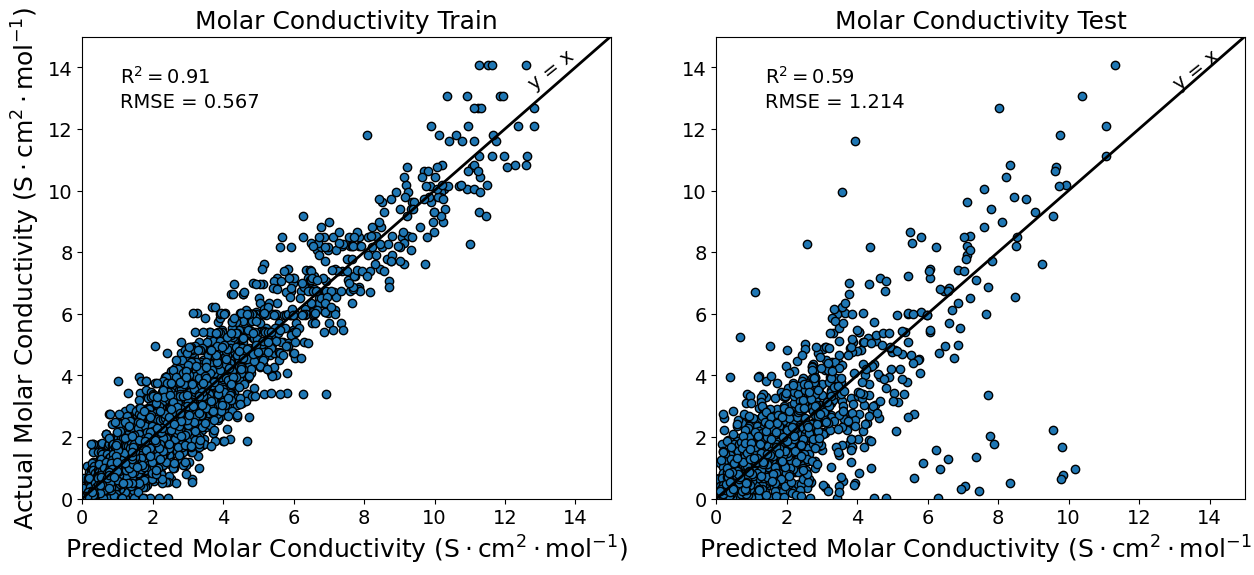

In [85]:
# Here, we create a parity plot figure for our model predictions.

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6)) # Create our side-by-side figure.

# Plot the Training Data.
ax1.grid(color='gray',axis='both',alpha=0) # Set our background and axis.

ax1.tick_params(left=True, bottom=True, labelleft = True, labelbottom=True, labelsize=14) # Set Axes.
ax1.set_facecolor('white') # Set facecolor.

# Set axes to min and max values.
ax1.set_xlim(np.floor(Final_Train_Target.min()), np.ceil(Final_Train_Target.max()))
ax1.set_ylim(np.floor(Final_Train_Target.min()), np.ceil(Final_Train_Target.max()))

# Create axes labels.
ax1.set_xlabel('Predicted ' + Prop_name + ' ' + Units, fontsize=18)
ax1.set_ylabel('Actual ' + Prop_name + ' ' + Units, fontsize=18)

ax1.set_title(Prop_name + ' Train', fontsize=18) # Create title.

ax1.scatter(Final_Train_Predictions, Final_Train_Target, edgecolors='black') # Plot data points.
ax1.plot([0, np.ceil(Final_Train_Target.max())], [0, np.ceil(Final_Train_Target.max())], color = 'black', linewidth = 2) # Plot x=y line.

# Print labels on figure.
ax1.annotate('$\mathregular{R^{2}=}$'+str(np.round(r2_score(Final_Train_Target, Final_Train_Predictions),2)),(0.08,0.82), xycoords = 'figure fraction', fontsize=14)
ax1.annotate('RMSE = '+str(np.round(np.sqrt(mean_squared_error(Final_Train_Target, Final_Train_Predictions)),3)),(0.08,0.78), xycoords = 'figure fraction',fontsize=14)
ax1.annotate('y = x ', (0.35,0.81), xycoords = 'figure fraction', rotation=38.6, fontsize=14)


# Plot the Testing Data.
ax2.grid(color='gray',axis='both',alpha=0) # Set our background and axis.

ax2.tick_params(left=True, bottom=True, labelleft = True, labelbottom=True, labelsize=14) # Set Axes.
ax2.set_facecolor('white') # Set facecolor.

# Set axes to min and max values.
ax2.set_xlim(np.floor(Final_Train_Target.min()), np.ceil(Final_Train_Target.max()))
ax2.set_ylim(np.floor(Final_Train_Target.min()), np.ceil(Final_Train_Target.max()))

# Create axes labels.
ax2.set_xlabel('Predicted ' + Prop_name + ' ' + Units, fontsize=18)
# ax2.set_ylabel('Actual ' + Prop_name + ' ' + Units, fontsize=18) # Uncomment for left axis on right subfigure.

ax2.set_title(Prop_name + ' Test', fontsize=18) # Create title.

ax2.scatter(Final_Test_Predictions, Final_Test_Target, edgecolors='black') # Plot data points.
ax2.plot([0, np.ceil(Final_Train_Target.max())], [0, np.ceil(Final_Train_Target.max())], color = 'black', linewidth = 2) # Plot x=y line.

# Print labels on figure.
ax2.annotate('$\mathregular{R^{2}=}$'+str(np.round(r2_score(Final_Test_Target, Final_Test_Predictions),2)),(0.51,0.82), xycoords = 'figure fraction', fontsize=14)
ax2.annotate('RMSE = '+str(np.round(np.sqrt(mean_squared_error(Final_Test_Target, Final_Test_Predictions)),3)),(0.51,0.78), xycoords = 'figure fraction',fontsize=14)
ax2.annotate('y = x ', (0.78,0.81), xycoords = 'figure fraction', rotation=38.6, fontsize=14)

# Display Figure
plt.show()

# ***Check Performance Curves***

* Now let's check our performance curves. We would like our performance curves to show a minimization in model error. Here, we will plot the performance curves for individual k-folds and for the model as a whole (summing the 5 curves).

* If our overall model error curve converges to a steady value, then our model has successfully minimized error and is providing accurate results. If our overall model error curve does not converge, this means our model is not done training, and we must increase the number of epochs or increase our learning rate. If our model error curve inflected and began to increase again, this means we are overfitting, and we must reduce the number of epochs or decrease the learning rate to stop earlier.

* Note, a successfully converged model does not mean we have successfully modeled a relationship between our input and output data. Rather it only indicates that we successfully trained the neural network. This indicates that we can continue with evaluating the the model's performance. The model's success and accuracy must be evaluated independently using error metrics, your scientific expertise, and and your scientific intuition.

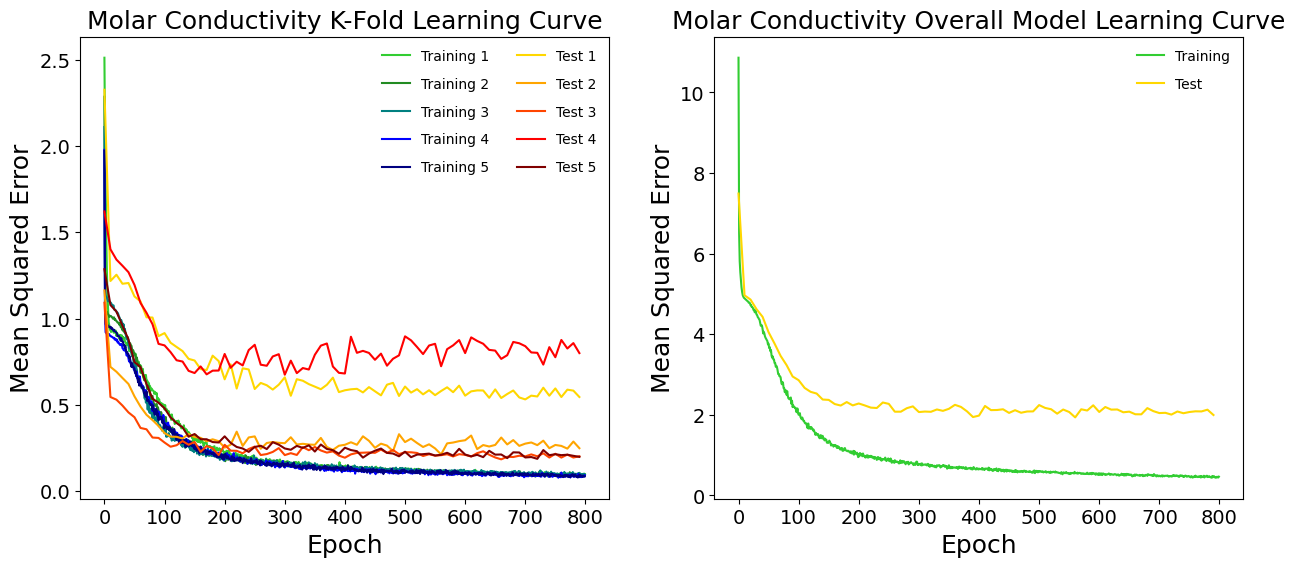

In [86]:
# Here, we create a training curve plot figure for our model's training.

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6)) # Create our side-by-side figure.

# Plot the each k-fold model learning curve.
ax1.grid(color='gray',axis='both',alpha=0) # Set our background and axis.

ax1.tick_params(left=True, bottom=True, labelleft = True, labelbottom=True, labelsize=14) # Set Axes.
ax1.set_facecolor('white') # Set facecolor.

# Create axes labels.
ax1.set_xlabel('Epoch', fontsize=18)
ax1.set_ylabel('Mean Squared Error', fontsize=18)

ax1.set_title(Prop_name + ' K-Fold Learning Curve', fontsize=18) # Create title.

# Plot the data for each training k-fold.
ax1.plot(np.arange(0,len(Training_Losses[0]),1), Training_Losses[0], color='limegreen', label='Training 1')
ax1.plot(np.arange(0,len(Training_Losses[1]),1), Training_Losses[1], color='forestgreen', label='Training 2')
ax1.plot(np.arange(0,len(Training_Losses[2]),1), Training_Losses[2], color='teal', label='Training 3')
ax1.plot(np.arange(0,len(Training_Losses[3]),1), Training_Losses[3], color='blue', label='Training 4')
ax1.plot(np.arange(0,len(Training_Losses[4]),1), Training_Losses[4], color='navy', label='Training 5')

# Plot the data for each test k-fold.
ax1.plot(np.arange(0,len(Test_Losses[0])*Test_check,Test_check), Test_Losses[0], color='gold', label='Test 1')
ax1.plot(np.arange(0,len(Test_Losses[1])*Test_check,Test_check), Test_Losses[1], color='orange', label='Test 2')
ax1.plot(np.arange(0,len(Test_Losses[2])*Test_check,Test_check), Test_Losses[2], color='orangered', label='Test 3')
ax1.plot(np.arange(0,len(Test_Losses[3])*Test_check,Test_check), Test_Losses[3], color='red', label='Test 4')
ax1.plot(np.arange(0,len(Test_Losses[4])*Test_check,Test_check), Test_Losses[4], color='maroon', label='Test 5')

ax1.legend(frameon=True, framealpha=0, fontsize=10, title_fontsize=12,  markerscale=1.75, labelspacing=1, ncol=2, columnspacing= 2) # Set the plot legend.


# Plot the overall model cumulative learning curve.
ax2.grid(color='gray',axis='both',alpha=0) # Set our background and axis.

ax2.tick_params(left=True, bottom=True, labelleft = True, labelbottom=True, labelsize=14) # Set Axes.
ax2.set_facecolor('white') # Set facecolor.

# Create axes labels.
ax2.set_xlabel('Epoch', fontsize=18)
ax2.set_ylabel('Mean Squared Error', fontsize=18)

ax2.set_title(Prop_name + ' Overall Model Learning Curve', fontsize=18) # Create title.

# Plot the cumulative data for the training and test sets.
ax2.plot(np.arange(0,len(Training_Losses[0]),1), Training_Losses[0]+Training_Losses[1]+Training_Losses[2]+Training_Losses[3]+Training_Losses[4], color='limegreen', label='Training')
ax2.plot(np.arange(0,len(Test_Losses[0])*Test_check,Test_check), Test_Losses[0]+Test_Losses[1]+Test_Losses[2]+Test_Losses[3]+Test_Losses[4], color='gold', label='Test')

ax2.legend(frameon=True, framealpha=0, fontsize=10, title_fontsize=12,  markerscale=1.75, labelspacing=1, ncol=1, columnspacing= 0) # Set the plot legend.

# Display Figure
plt.show()